In [1]:
from dataset import (
    get_dataset, 
    save_map, 
    save_pred_map_to_tif
)
from metrics import (
    get_metrics,
    get_classification_metrics,
    get_feature_importances, 
    get_catboost_importances, 
)
from vis import (
    plot_image,
    plot_mask,
    plot_SCL,
    draw_maps,
)

import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import wandb
import rasterio
import numpy as np
import tifffile as tiff
import wandb
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2   

/beegfs/home/alina.smolina/forest-co2/dataset.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


* Инициализировать датасет для инференса пород, высоты, возраста, базальной площади для каждой даты
* Загрузить все 4 модели
* Сделать пересчет в запас для каждой даты
* Найти метрики для запаса для каждой даты

In [2]:
path_S2B_list = [
    './data/tile_UTM38N/20180730/',
    './data/tile_UTM38N/20180804/',
    './data/tile_UTM38N/20180827/',
    './data/tile_UTM38N/20180911/',
    './data/tile_UTM38N/20190608/',
    './data/tile_UTM38N/20190613/',
    './data/tile_UTM38N/20200604/',
    './data/tile_UTM38N/20200709/',
]

channels = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target = 'volume'

In [3]:
# Get table with types and ages
y0, x0 = 6000, 0
window_n = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

y0, x0 = 0, 5700
window_r = Window.from_slices((y0, y0 + 7000), (x0, x0 + 10000))


### Test
y0, x0 = 7500, 2700
window_k = Window.from_slices((y0, y0 + 3000), (x0, x0 + 1200))

In [4]:
## Stacking of several dates
def stack_several_dates_dataset(path_S2B_list, 
                              target, 
                              channels_list=['B02'], 
                              window=None, 
                              indices=False):
    dataset_list = []
    ch_list = channels_list + [target]

    for path_S2B in path_S2B_list:
        dataset = get_dataset(
            path_S2B, 
            channels_list=ch_list, 
            window=window, 
            visualise=False, 
            indices=indices)
        
        dataset = dataset[dataset[target] > 0]
        
        #### классификация:
        # dataset = dataset.query('(`1layer_main_species` == 1) | (`1layer_main_species` == 2) | (`1layer_main_species` == 3) | (`1layer_main_species` == 4) | (`1layer_main_species` == 5) | (`1layer_main_species` == 9)')

        # dataset = dataset[dataset[target] != 3]
        
        dataset_list.append(dataset)

    dataset = pd.concat(dataset_list)
        
    return dataset

In [5]:
from catboost import CatBoostClassifier, CatBoostRegressor
model_species = CatBoostClassifier()
model_species.load_model('weights/species-10bands-indices-10000')

In [6]:
model_age = CatBoostRegressor()
model_age.load_model('weights/age-10bands-indices')

In [7]:
model_height = CatBoostRegressor()
model_height.load_model('weights/height-10bands-indices')

In [8]:
model_area = CatBoostRegressor()
model_area.load_model('weights/basal-area-10bands-indices')

In [9]:
def predict_volume(X):
    basal_area = model_area.predict(X)
    basal_area = np.where(basal_area > 0, basal_area, 0)
    
    height = model_height.predict(X)
    height = np.where(height > 0, height, 0)
    
    volume = height * basal_area
    volume = np.where((height > 0) & (basal_area > 0), volume, 0)
    
    return volume

In [10]:
def predict_stock(X):
    age = model_age.predict(X)
    age = np.where(age > 0, age, 0)
    
    species = model_species.predict(X)
    
    volume = predict_volume(X)
    
    species_age = {
    1: [[0, 40], [40, 100], [100, 120], [120, 1000]],
    2: [[0, 20], [20, 40], [40, 50], [50, 1000]],
    3: [[0, 20], [20, 40], [40, 50], [50, 1000]],
    4: [[0, 20], [20, 30], [30, 40], [40, 1000]],
    5: [[0, 40], [40, 100], [100, 120], [120, 1000]],
              }

    species_coeff = {
        1: [0.409, 0.426, 0.431, 0.436],
        2: [0.528, 0.534, 0.533, 0.528],
        3: [0.4, 0.4, 0.4, 0.4],
        4: [0.403, 0.426, 0.431, 0.444],
        5: [0.452, 0.454, 0.454, 0.449],
                    }

    C_content = {
        1: 0.5,
        2: 0.47,
        3: 0.48,
        4: 0.47, 
        5: 0.5
    }
    
    BCEF_species = {
    1: np.zeros(volume.shape),
    2: np.zeros(volume.shape), 
    3: np.zeros(volume.shape),
    4: np.zeros(volume.shape),
    5: np.zeros(volume.shape),
               }

    tmp_shape = np.ones(volume.shape)

    for sp in BCEF_species.keys():
        for age_ind in range(4):
            specimen_mask = np.where(species == sp, 1, 0) 
            age_condition = (species_age[sp][age_ind][0] * tmp_shape < age) & (age <= species_age[sp][age_ind][1] * tmp_shape)
            BCEF_species[sp] += np.where(age_condition, np.squeeze(specimen_mask * species_coeff[sp][age_ind]), 0)
        BCEF_species[sp] *= C_content[sp]

    carbon_stock = volume * sum(BCEF_species.values())
    carbon_stock = np.where(carbon_stock > 0, carbon_stock, 0)
    
    return carbon_stock

In [11]:
test_list = []
ch_list = channels + [target]

for path_S2B in path_S2B_list:
    dataset = get_dataset(
        path_S2B, 
        channels_list=ch_list, 
        window=window_k, 
        visualise=False, 
        indices=True)

    dataset = dataset[dataset[target] > 0]

    #### классификация:
    # dataset = dataset.query('(`1layer_main_species` == 1) | (`1layer_main_species` == 2) | (`1layer_main_species` == 3) | (`1layer_main_species` == 4) | (`1layer_main_species` == 5) | (`1layer_main_species` == 9)')

    test_list.append(dataset)

In [12]:
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_absolute_error, 
    mean_squared_error, 
    confusion_matrix, 
    classification_report
)

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



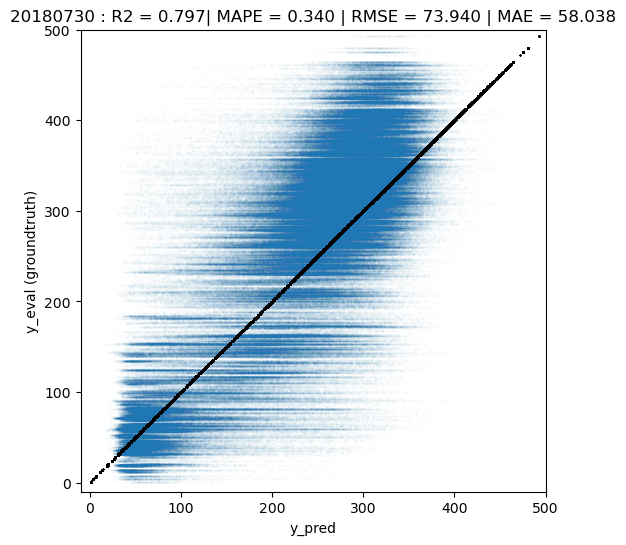

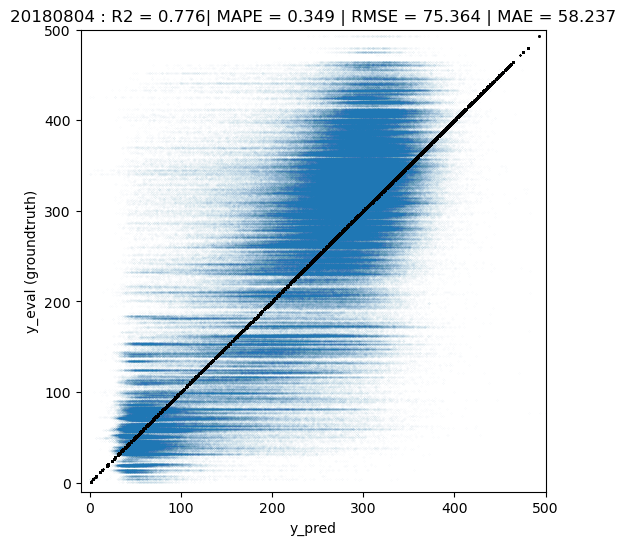

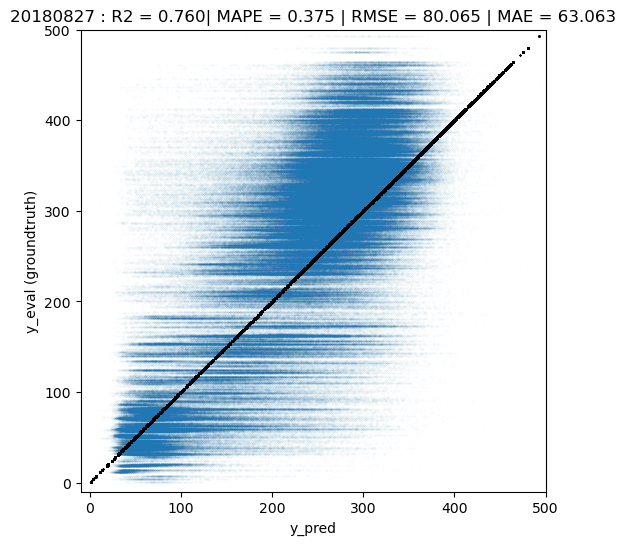

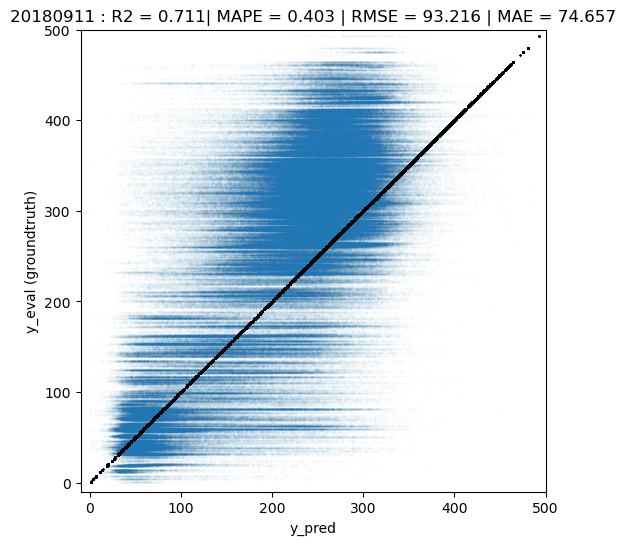

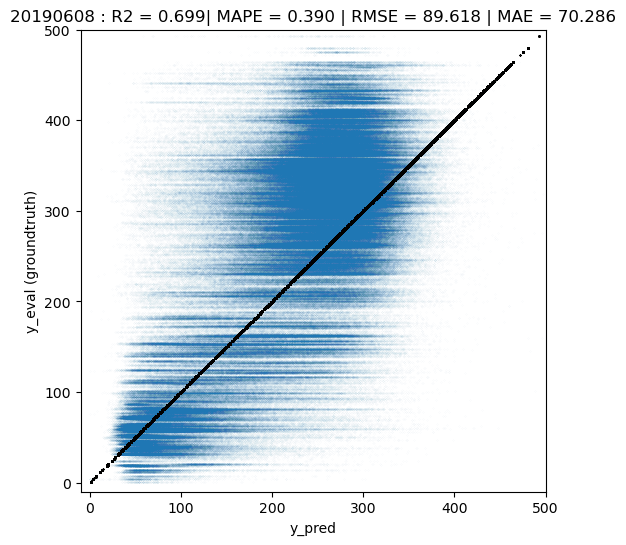

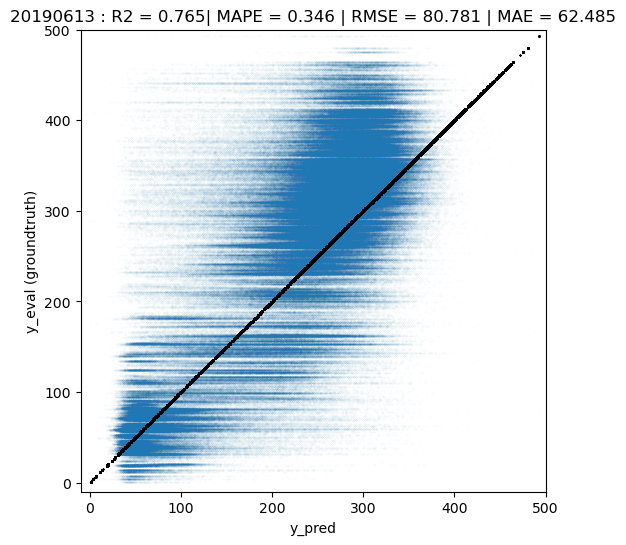

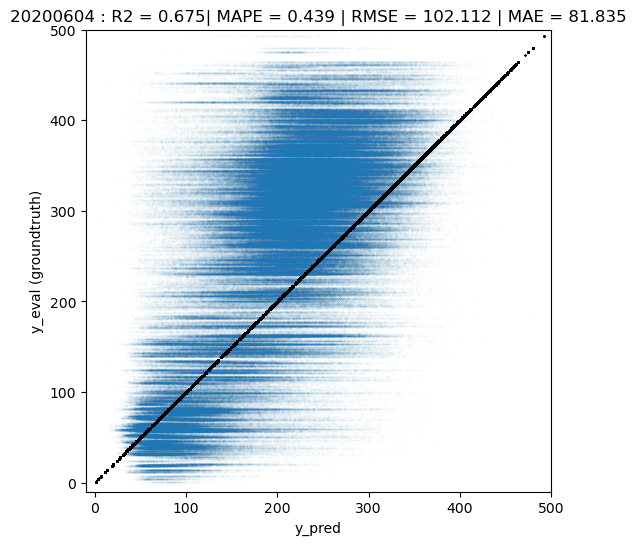

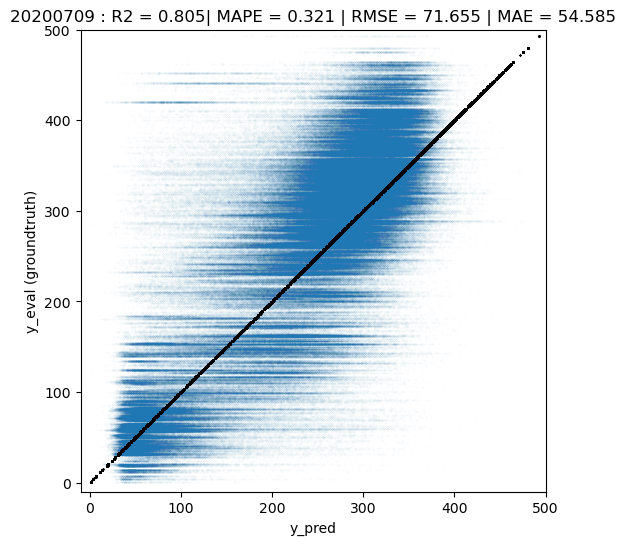

In [13]:
limits = [-10, 500]
names = [path.split('/')[-2] for path in path_S2B_list]
result_table = wandb.Table(columns=['name', 'R2', 'MAPE', 'RMSE', 'MAE'])

for i, name in enumerate(names):
    test_dataset = test_list[i]
    Y_eval = test_dataset[target]
    X_eval = test_dataset.drop(labels=[target, 'x', 'y'], axis=1)
    
    Y_pred = predict_volume(X_eval) # test_dataset['var1']
    R2 = np.corrcoef(Y_eval, Y_pred)[0][1]
    MAPE = mean_absolute_percentage_error(Y_eval, Y_pred)
    RMSE = mean_squared_error(Y_eval, Y_pred, squared=False)
    MAE = mean_absolute_error(Y_eval, Y_pred)
    fig = plt.figure(figsize=(6,6)) 
    plt.scatter(Y_pred, Y_eval, s=0.01, alpha=0.1)
    plt.scatter(Y_eval, Y_eval, s=0.01, color='black')
    plt.xlabel('y_pred')
    plt.ylabel('y_eval (groundtruth)')
    plt.xlim(limits)
    plt.ylim(limits)
    plt.title(f'{name} : R2 = {R2:.3f}| MAPE = {MAPE:.3f} | RMSE = {RMSE:.3f} | MAE = {MAE:.3f}')
    
    result_table.add_data(name, R2, MAPE, RMSE, MAE)
    # wandb.log({name: wandb.Image(fig)})

In [40]:
d = [row[0] for row in result_table.data]
print(*d, sep='\n')

20180730
20180804
20180827
20180911
20190608
20190613
20200604
20200709


In [51]:
a = [round(row[1], 3) for row in result_table.data] # date, R2, MAPE, RMSE, MAE

In [52]:
print(*a, sep='\n')
print(round(np.mean(a), 2))

0.797
0.776
0.76
0.711
0.699
0.765
0.675
0.805
0.75
